The purpose of this notebook is to read the full enzyme database into a notebook, and to begin to explore promiscuous enzymes, and how to pull data on linked reactions

In [6]:
# imports

from Bio.KEGG import REST
from Bio.KEGG import Enzyme
from Bio.KEGG import Compound

import gzip
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [7]:
# function to read data directly from the text file instead

def enzyme_records_to_df(file_path):
    """
    Input should be a filepath string pointing to a gzipped text file of KEGG enzyme records.
    Function parses all records using Biopython.Bio.KEGG.Enzyme parser, and returns a pandas dataframe.
    """
    enzyme_fields = [method for method in dir(Enzyme.Record()) if not method.startswith('_')]
    data_matrix = []

    with gzip.open(file_path, 'rt') as file:
        for record in Enzyme.parse(file):
            data_matrix.append([getattr(record, field) for field in enzyme_fields])
    
    enzyme_df = pd.DataFrame(data_matrix, columns=enzyme_fields)
    return enzyme_df

In [9]:
# read in enzyme data

enzyme_df = enzyme_records_to_df('../metamoles/tests/test_kegg_enzyme_records.txt.gz')

In [ ]:
enzyme_df.columns == ['classname', 'cofactor', 'comment', 'dblinks', 'disease', 'effector',
       'entry', 'genes', 'inhibitor', 'name', 'pathway', 'product', 'reaction',
       'structures', 'substrate', 'sysname']

In [20]:
enzyme_df['entry'].tolist() == ['1.1.1.1', '1.1.1.2', '1.1.1.3']

['1.1.1.1', '1.1.1.2', '1.1.1.3']

In [21]:
enzyme_df.head()

,classname,cofactor,comment,dblinks,disease,effector,entry,genes,inhibitor,name,pathway,product,reaction,structures,substrate,sysname
0,"[Oxidoreductases;, Acting on the CH-OH group o...",[],[A zinc protein. Acts on primary or secondary ...,"[(ExplorEnz - The Enzyme Database, [1.1.1.1]),...",[],[],1.1.1.1,"[(HSA, [124, 125, 126, 127, 128, 130, 131]), (...",[],"[alcohol dehydrogenase, aldehyde reductase, AD...","[(PATH, ec00010, Glycolysis / Gluconeogenesis)...","[aldehyde [CPD:C00071], NADH [CPD:C00004], H+ ...",[(1) a primary alcohol + NAD+ = an aldehyde + ...,[],"[primary alcohol [CPD:C00226], NAD+ [CPD:C0000...",[alcohol:NAD+ oxidoreductase]
1,"[Oxidoreductases;, Acting on the CH-OH group o...",[],[A zinc protein. Some members of this group ox...,"[(ExplorEnz - The Enzyme Database, [1.1.1.2]),...",[],[],1.1.1.2,"[(HSA, [10327]), (PTR, [741418]), (PPS, [10099...",[],"[alcohol dehydrogenase (NADP+), aldehyde reduc...","[(PATH, ec00010, Glycolysis / Gluconeogenesis)...","[aldehyde [CPD:C00071], NADPH [CPD:C00005], H+...",[an alcohol + NADP+ = an aldehyde + NADPH + H+...,[],"[alcohol [CPD:C00069], NADP+ [CPD:C00006]]",[alcohol:NADP+ oxidoreductase]
2,"[Oxidoreductases;, Acting on the CH-OH group o...",[],[The yeast enzyme acts most rapidly with NAD+;...,"[(ExplorEnz - The Enzyme Database, [1.1.1.3]),...",[],[],1.1.1.3,"[(NVE, [NEMVE_v1g225948]), (ATH, [AT1G31230, A...",[],"[homoserine dehydrogenase, HSDH, HSD]","[(PATH, ec00260, Glycine, serine and threonine...","[L-aspartate 4-semialdehyde [CPD:C00441], NADH...",[L-homoserine + NAD(P)+ = L-aspartate 4-semial...,[],"[L-homoserine [CPD:C00263], NAD+ [CPD:C00003],...",[L-homoserine:NAD(P)+ oxidoreductase]


In [22]:
# apply a boolean mask to the dataframe to select only rows in which the number of reaction entries is > 1

promiscuous_df = enzyme_df[[True if len(rxn) > 1 else False for rxn in enzyme_df['reaction']]]

In [23]:
# how many promiscuous enzymes are there?

promiscuous_df.shape

(1, 16)

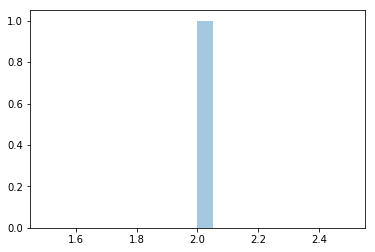

In [24]:
# histogram of total reactions per enzyme EC category

reactions = [len(rxn) for rxn in promiscuous_df['reaction']]

hist = sns.distplot(reactions, bins=20, kde=False, norm_hist=False)

In [25]:
# example product field

prod_example = enzyme_df.iloc[0]['product']
prod_example

['aldehyde [CPD:C00071]',
 'NADH [CPD:C00004]',
 'H+ [CPD:C00080]',
 'ketone [CPD:C01450]']

In [26]:
# test pull CPD record from KEGG
# note: this doesn't appear to work if CPD is in caps

cpd_entry_71 = (REST.kegg_get('cpd:c00071').read())

In [27]:
cpd_entry_71

'ENTRY       C00071                      Compound\nNAME        Aldehyde;\n            RCHO\nFORMULA     CHOR\nCOMMENT     Generic compound in reaction hierarchy\nREACTION    R00538 R00544 R00623 R00625 R00631 R00634 R00635 R00636 \n            R00637 R00638 R00639 R01409 R01853 R01854 R02745 R03415 \n            R07158 R07210 R07326 R07328 R08372 R09359 R09480 R10388 \n            R10713 R10911 R10912 R11354\nPATHWAY     map00071  Fatty acid degradation\nENZYME      1.1.1.1         1.1.1.2         1.1.1.71        1.1.2.7         \n            1.1.3.13        1.1.9.1         1.1.99.20       1.2.1.3         \n            1.2.1.4         1.2.1.5         1.2.3.1         1.2.5.2         \n            1.2.7.5         1.2.99.6        1.2.99.7        1.4.3.4         \n            1.4.3.21        1.7.3.1         1.14.14.5       3.3.2.2         \n            4.1.1.1         4.1.2.10        4.1.2.11        4.1.2.47\nDBLINKS     PubChem: 3371\n            ChEBI: 17478\nATOM        3\n            1

In [28]:
# fiddle with regex to get CPD number

prod_example.append('[cpd:c00071]')

regex = '\[CPD:(C\d{5})]'
print(re.findall(regex, str(prod_example), re.IGNORECASE))

['C00071', 'C00004', 'C00080', 'C01450', 'c00071']


In [29]:
prod_example

['aldehyde [CPD:C00071]',
 'NADH [CPD:C00004]',
 'H+ [CPD:C00080]',
 'ketone [CPD:C01450]',
 '[cpd:c00071]']

In [30]:
# function that extracts list of KEGG compound IDs from product or substrate field of enzyme entry
# regex reference: https://regex101.com/

# changed this to leave out the brackets
def extract_KEGG_compound_IDs(field):
    """
    This function uses regular expressions to extract the KEGG compound IDs from a product or substrate field
    in an enzyme record (or other KEGG record)
    """
    
    cpd_list = []
    regex = 'CPD:(C\d+)'    # matches '[CPD: ' characters exactly, captures 'C' + any number of digits (\d+), befor another literal ']' character
    for entry in field:
        ids = re.findall(regex, str(entry), re.IGNORECASE)
        for i in ids:
            cpd_list.append(i)
    
    return cpd_list


In [31]:
enzyme_df.head()

,classname,cofactor,comment,dblinks,disease,effector,entry,genes,inhibitor,name,pathway,product,reaction,structures,substrate,sysname
0,"[Oxidoreductases;, Acting on the CH-OH group o...",[],[A zinc protein. Acts on primary or secondary ...,"[(ExplorEnz - The Enzyme Database, [1.1.1.1]),...",[],[],1.1.1.1,"[(HSA, [124, 125, 126, 127, 128, 130, 131]), (...",[],"[alcohol dehydrogenase, aldehyde reductase, AD...","[(PATH, ec00010, Glycolysis / Gluconeogenesis)...","[aldehyde [CPD:C00071], NADH [CPD:C00004], H+ ...",[(1) a primary alcohol + NAD+ = an aldehyde + ...,[],"[primary alcohol [CPD:C00226], NAD+ [CPD:C0000...",[alcohol:NAD+ oxidoreductase]
1,"[Oxidoreductases;, Acting on the CH-OH group o...",[],[A zinc protein. Some members of this group ox...,"[(ExplorEnz - The Enzyme Database, [1.1.1.2]),...",[],[],1.1.1.2,"[(HSA, [10327]), (PTR, [741418]), (PPS, [10099...",[],"[alcohol dehydrogenase (NADP+), aldehyde reduc...","[(PATH, ec00010, Glycolysis / Gluconeogenesis)...","[aldehyde [CPD:C00071], NADPH [CPD:C00005], H+...",[an alcohol + NADP+ = an aldehyde + NADPH + H+...,[],"[alcohol [CPD:C00069], NADP+ [CPD:C00006]]",[alcohol:NADP+ oxidoreductase]
2,"[Oxidoreductases;, Acting on the CH-OH group o...",[],[The yeast enzyme acts most rapidly with NAD+;...,"[(ExplorEnz - The Enzyme Database, [1.1.1.3]),...",[],[],1.1.1.3,"[(NVE, [NEMVE_v1g225948]), (ATH, [AT1G31230, A...",[],"[homoserine dehydrogenase, HSDH, HSD]","[(PATH, ec00260, Glycine, serine and threonine...","[L-aspartate 4-semialdehyde [CPD:C00441], NADH...",[L-homoserine + NAD(P)+ = L-aspartate 4-semial...,[],"[L-homoserine [CPD:C00263], NAD+ [CPD:C00003],...",[L-homoserine:NAD(P)+ oxidoreductase]


In [34]:
l = extract_KEGG_compound_IDs(enzyme_df['product'])
print(l)

['C00071', 'C00004', 'C00080', 'C01450', 'c00071', 'C00071', 'C00005', 'C00080', 'C00441', 'C00004', 'C00005', 'C00080']


In [15]:
# # test out KEGG compound extraction function
# # this works but takes a very long time

# test_df = promiscuous_df[:5]

# test_df['compound_ids'] = test_df['product'].apply(extract_KEGG_compound_IDs)

# test_df

In [51]:
# try extracting entry, classname, and name for each product compound id, and creating new dataframe


def explode_dataframe(dataframe, explosion_function, explosion_target_field, fields_to_include):
    """
    This function applies the input explosion_function to the target field in each row of a dataframe.
    Each item in the output of the explosion_function is an anchor for a new row in the new dataframe.
    All of the supplied fields_to_include are added to the explosion item, and appended to the new dataframe row.
    
    dataframe, 
    explosion_function, 
    explosion_target_field, 
    fields_to_include
    """
    
    new_rows = []
    for _, row in dataframe.iterrows():
        explosion_list = explosion_function(row[explosion_target_field])
        for item in explosion_list:
            row_data = [row[field] for field in fields_to_include]
            row_data.append(item)
            new_rows.append(row_data)

    fields_to_include.append(explosion_target_field)
    new_df = pd.DataFrame(new_rows, columns=fields_to_include)
    
    return new_df


In [55]:
# test explode_dataframe function

exploded_df = explode_dataframe(enzyme_df, extract_KEGG_compound_IDs, 'product', ['entry'])

exploded_df.shape

(12, 2)

In [58]:
print(exploded_df['product'].tolist())

['C00071', 'C00004', 'C00080', 'C01450', 'c00071', 'C00071', 'C00005', 'C00080', 'C00441', 'C00004', 'C00005', 'C00080']


In [18]:
# run explode dataframe function on full promiscuous enzyme dataframe

expanded_prom_enzymes_df = explode_dataframe(promiscuous_df, extract_KEGG_compound_IDs, 'product', ['entry'])

In [19]:
# looks like a total of 1878 product compound/enzyme pairs

expanded_prom_enzymes_df.head()

,entry,product
0,1.1.1.1,C00071
1,1.1.1.1,C00004
2,1.1.1.1,C00080
3,1.1.1.1,C01450
4,1.1.1.1,c00071


In [20]:
# no empty cells - this is good

expanded_prom_enzymes_df.isnull().sum()

entry      0
product    0
dtype: int64

## Starting work here

In [21]:
expanded_prom_enzymes_df.shape

(1879, 2)

In [22]:
#cofactor removal 
cofactor_df = pd.read_csv("../datasets/cofactor_list.csv")
cofactor_list = extract_KEGG_compound_IDs(cofactor_df['CPD'])
len(cofactor_list)

37

In [23]:
# remove rows that contain cofactors

bool_mask = [False if cpd in cofactor_list else True for cpd in expanded_prom_enzymes_df['product']]
clean_enzyme_df = expanded_prom_enzymes_df[bool_mask]


In [24]:
clean_enzyme_df.shape

(1221, 2)

In [25]:
# one duplicate enzyme - compound entry 

deduplicated = clean_enzyme_df.drop_duplicates()
deduplicated.shape

(1220, 2)

In [26]:
clean_enzyme_df.head()

,entry,product
0,1.1.1.1,C00071
3,1.1.1.1,C01450
4,1.1.1.1,c00071
5,1.1.1.38,C00022
8,1.1.1.40,C00022


In [27]:
# check PubChem id number lengths & for empty cells
# looks like there are some empty fields, as well as some longer id numbers
# we should look into these more, but for now I will charge ahead

def check_length_dist(dataframe, field):
    id_lengths = [len(data) for data in dataframe[field]]

    values, counts = np.unique(id_lengths, return_counts=True)

    for i in range(len(values)):
        print("{}: {}".format(values[i], counts[i]))

    print("\ntotal numbers: {}\ncdataframe shape: {}".format(counts.sum(), dataframe.shape))

In [28]:
check_length_dist(clean_enzyme_df, 'entry')

7: 131
8: 377
9: 342
10: 266
11: 105

total numbers: 1221
cdataframe shape: (1221, 2)


In [60]:
# function to create two dataframes - one of positive data (enzyme - compound pairs that exist in the dataset)
# and one of negative data (all enzyme - compound pairs that do not exist in the dataset)

def neg_data_matchmaker(dataframe, enzyme_field, compound_field):
    """neg_data_matchmaker creates two dataframes. One dataframe is positive data that contains all the 
    enzyme-compound pairs that exist in the dataset. The second data frame is negative data made from matching 
    all enzyme-compound pairs that do not exist in the dataset.
    
    Inputs
    dataframe: pandas dataframe
    enzyme_field: string identifier denoting which column contains enzyme ids
    compound_field: string identifier denoting which column contains compound ids
    
    Outputs
    positive_df: pandas dataframe with fields 'enzyme', 'product', 'reacts'
    negative_df: pandas dataframe with fields 'enzyme', 'product', 'reacts'
    """
    unique_enzymes = set(dataframe[enzyme_field].unique())
    # set of all unique enzymes in provided dataframes
    unique_cpds = set(dataframe[compound_field].unique())
    # set of all unique compounds in provided dataframe

    positive_data = []
    negative_data = []
    # initialize empty lists

    for enzyme in unique_enzymes:
    # iterate through unique enzyme set
        working_prods = set(dataframe[dataframe[enzyme_field] == enzyme][compound_field].unique())
        # unique set of all products reported to reaction with this enzyme in provided dataset
        non_working_prods = (unique_cpds - working_prods)
        # set math of all remaining products in the dataset minus those reported to react

        reactions = [{'reacts':1.0, 'enzyme':enzyme, 'product':product} for product in working_prods]
        # create new entry for each positive reaction
        non_reactions = [{'reacts':0.0, 'enzyme':enzyme, 'product':product} for product in non_working_prods]
        # create new entry for each negative reaction

        positive_data.extend(reactions)
        # add positive reactions to master list
        negative_data.extend(non_reactions)
        # add negative reactions to master list

    positive_df = pd.DataFrame(positive_data)
    negative_df = pd.DataFrame(negative_data)
    
    return positive_df, negative_df


In [61]:
pos_df, neg_df = neg_data_matchmaker(exploded_df, 'entry', 'product')

In [62]:
pos_df.shape

(12, 3)

In [63]:
neg_df.shape

(9, 3)

In [69]:
print(neg_df['product'].tolist())

['C01450', 'C00441', 'C00004', 'c00071', 'C00441', 'C00005', 'C01450', 'C00071', 'c00071']


In [69]:
unique_cpds.remove('C00022')  

In [52]:
len(unique_cpds)

877

In [35]:
# function to read compound data from text file directly into dataframe

def compound_records_to_df(file_path):
    """
    Input should be a filepath string pointing to a gzipped text file of KEGG enzyme records.
    Function parses all records using Biopython.Bio.KEGG.Compound parser, and returns a pandas dataframe.
    """
    compound_fields = [method for method in dir(Compound.Record()) if not method.startswith('_')]
    data_matrix = []

    with gzip.open(file_path, 'rt') as file:
        for record in Compound.parse(file):
            data_matrix.append([getattr(record, field) for field in compound_fields])
    
    compound_df = pd.DataFrame(data_matrix, columns=compound_fields)
    return compound_df

In [36]:
!ls ../metamoles/tests/

__init__.py                       test_kegg_compound_records.txt.gz
test_core.py                      test_kegg_enzyme_records.txt.gz


In [38]:
# read in compound data

compound_df = compound_records_to_df('../metamoles/tests/test_kegg_compound_records.txt.gz')

In [40]:
# looks like there are 18505 entries

compound_df.shape

(55, 8)

In [43]:
compound_df.columns

Index(['dblinks', 'entry', 'enzyme', 'formula', 'mass', 'name', 'pathway',
       'structures'],
      dtype='object')

In [45]:
print(compound_df['entry'].tolist())

['C00001', 'C00002', 'C00003', 'C00004', 'C00005', 'C00006', 'C00007', 'C00008', 'C00009', 'C00010', 'C00011', 'C00012', 'C00013', 'C00014', 'C00015', 'C00016', 'C00017', 'C00018', 'C00019', 'C00020', 'C00021', 'C00022', 'C00023', 'C00024', 'C00025', 'C00026', 'C00027', 'C00028', 'C00029', 'C00030', 'C00031', 'C00032', 'C00033', 'C00034', 'C00035', 'C00036', 'C00037', 'C00038', 'C00039', 'C00040', 'C00041', 'C00042', 'C00043', 'C00044', 'C00045', 'C00046', 'C00047', 'C00048', 'C00049', 'C00050', 'C00051', 'C00052', 'C00053', 'C00054', 'C00055']


In [46]:
# function to extract PubChem compound ID:

def extract_PubChem_id(field):
    """
    This function uses regular expressions to extract the PubChem compound IDs from a field in a record
    """

    regex = "'PubChem', \[\'(\d+)\'\]\)" # matches "'PubChem', ['" characters exactly, then captures any number of digits (\d+), before another literal "']" character match
    ids = re.findall(regex, str(field), re.IGNORECASE)
    if len(ids) > 0:
        pubchem_id = ids[0]
    else:
        pubchem_id = ''
    
    return pubchem_id

In [47]:
# extract PubChem compound IDs to a new field in compound dataframe

PubChemID_list = []

for _, row in compound_df.iterrows():
    pubchem_id = extract_PubChem_id(row['dblinks'])
    PubChemID_list.append(pubchem_id)
    
compound_df['PubChem'] = PubChemID_list

In [49]:
print(PubChemID_list)

['3303', '3304', '3305', '3306', '3307', '3308', '3309', '3310', '3311', '3312', '3313', '3314', '3315', '3316', '3317', '3318', '3319', '3320', '3321', '3322', '3323', '3324', '3325', '3326', '3327', '3328', '3329', '3330', '3331', '3332', '3333', '3334', '3335', '3336', '3337', '3338', '3339', '3340', '3341', '3342', '3343', '3344', '3345', '3346', '3347', '3348', '3349', '3350', '3351', '3352', '3353', '3354', '3355', '3356', '3357']


In [31]:
# check PubChem id number lengths & for empty cells
# looks like there are some empty fields, as well as some longer id numbers
# we should look into these more, but for now I will charge ahead

id_lengths = [len(field) for field in compound_df['PubChem']]

values, counts = np.unique(id_lengths, return_counts=True)

for i in range(len(values)):
    print("{}: {}".format(values[i], counts[i]))
    
print("\ntotal numbers: {}\ncompound_df shape: {}".format(counts.sum(), compound_df.shape))

0: 197
4: 5835
5: 4198
6: 813
7: 141
8: 3582
9: 3739

total numbers: 18505
compound_df shape: (18505, 9)


In [32]:
# final step: join compound dataframe onto enzyme dataframe

joint_enzyme_compound_df = expanded_prom_enzymes_df.merge(compound_df, left_on='product', right_on='entry')

In [33]:
joint_enzyme_compound_df.head()

,entry_x,name_x,product,dblinks,entry_y,enzyme,formula,mass,name_y,pathway,structures,PubChem
0,1.1.1.1,"[alcohol dehydrogenase, aldehyde reductase, AD...",C00071,"[(PubChem, [3371]), (ChEBI, [17478])]",C00071,"[1.1.1.1, 1.1.1.2, 1.1.1.71, 1.1.2.7, 1.1.3.13...",CHOR,,"[Aldehyde, RCHO]","[(PATH, map00071, Fatty acid degradation)]",[],3371
1,3.3.2.2,"[lysoplasmalogenase, alkenylglycerophosphochol...",C00071,"[(PubChem, [3371]), (ChEBI, [17478])]",C00071,"[1.1.1.1, 1.1.1.2, 1.1.1.71, 1.1.2.7, 1.1.3.13...",CHOR,,"[Aldehyde, RCHO]","[(PATH, map00071, Fatty acid degradation)]",[],3371
2,1.1.1.1,"[alcohol dehydrogenase, aldehyde reductase, AD...",C00004,"[(CAS, [58-68-4]), (PubChem, [3306]), (ChEBI, ...",C00004,"[1.1.1.1, 1.1.1.3, 1.1.1.4, 1.1.1.6, 1.1.1.7, ...",C21H29N7O14P2,,"[NADH, DPNH, Reduced nicotinamide adenine dinu...","[(PATH, map00190, Oxidative phosphorylation), ...",[],3306
3,1.1.1.38,[malate dehydrogenase (oxaloacetate-decarboxyl...,C00004,"[(CAS, [58-68-4]), (PubChem, [3306]), (ChEBI, ...",C00004,"[1.1.1.1, 1.1.1.3, 1.1.1.4, 1.1.1.6, 1.1.1.7, ...",C21H29N7O14P2,,"[NADH, DPNH, Reduced nicotinamide adenine dinu...","[(PATH, map00190, Oxidative phosphorylation), ...",[],3306
4,1.1.1.85,"[3-isopropylmalate dehydrogenase, beta-isoprop...",C00004,"[(CAS, [58-68-4]), (PubChem, [3306]), (ChEBI, ...",C00004,"[1.1.1.1, 1.1.1.3, 1.1.1.4, 1.1.1.6, 1.1.1.7, ...",C21H29N7O14P2,,"[NADH, DPNH, Reduced nicotinamide adenine dinu...","[(PATH, map00190, Oxidative phosphorylation), ...",[],3306


In [34]:
# clean up columns, etc

joint_enzyme_compound_df.drop(['entry_y', 'enzyme', 'pathway', 'structures'], axis=1, inplace=True)

In [35]:
# rename columns

new_col_names = ['ec_number', 'enzyme_name', 'product_cpd', 'dblinks', 'product_formula', 'product_mass', 'product_name', 'pubchem_id']
new_col_dict = dict(zip(joint_enzyme_compound_df.columns, new_col_names))

joint_enzyme_compound_df.rename(columns=new_col_dict, inplace=True)
joint_enzyme_compound_df.sort_values(by=['ec_number']).head()


,ec_number,enzyme_name,product_cpd,dblinks,product_formula,product_mass,product_name,pubchem_id
0,1.1.1.1,"[alcohol dehydrogenase, aldehyde reductase, AD...",C00071,"[(PubChem, [3371]), (ChEBI, [17478])]",CHOR,,"[Aldehyde, RCHO]",3371
2,1.1.1.1,"[alcohol dehydrogenase, aldehyde reductase, AD...",C00004,"[(CAS, [58-68-4]), (PubChem, [3306]), (ChEBI, ...",C21H29N7O14P2,,"[NADH, DPNH, Reduced nicotinamide adenine dinu...",3306
93,1.1.1.1,"[alcohol dehydrogenase, aldehyde reductase, AD...",C01450,"[(PubChem, [4627]), (ChEBI, [17087])]",COR2,,"[Ketone, R-CO-R']",4627
33,1.1.1.1,"[alcohol dehydrogenase, aldehyde reductase, AD...",C00080,"[(PubChem, [3380]), (ChEBI, [15378, 24636])]",H,,"[H+, Hydron]",3380
5,1.1.1.110,"[aromatic 2-oxoacid reductase, (R)-aromatic la...",C00004,"[(CAS, [58-68-4]), (PubChem, [3306]), (ChEBI, ...",C21H29N7O14P2,,"[NADH, DPNH, Reduced nicotinamide adenine dinu...",3306


In [36]:
# check PubChem id number lengths & empty fields

id_lengths = [len(field) for field in joint_enzyme_compound_df['pubchem_id']]

values, counts = np.unique(id_lengths, return_counts=True)

for i in range(len(values)):
    print("{}: {}".format(values[i], counts[i]))
    
print("\ntotal numbers: {}\ncompound_df shape: {}".format(counts.sum(), joint_enzyme_compound_df.shape))

0: 54
4: 1339
5: 61
6: 12
7: 3
8: 117
9: 292

total numbers: 1878
compound_df shape: (1878, 8)


In [37]:
# examine 0 fields
# looks like these entries don't have a dblink for PubChem
# may be able to deal with these later, but for now we'll just have to move on

bool_mask = [True if length == 0 else False for length in id_lengths]

empty_pubchems = joint_enzyme_compound_df[bool_mask]

empty_pubchems

,ec_number,enzyme_name,product_cpd,dblinks,product_formula,product_mass,product_name,pubchem_id
503,1.3.1.114,"[3-dehydro-bile acid Delta4,6-reductase, baiN ...",C21906,[],C45H70N7O18P3S,,[3-Oxochol-4-en-24-oyl-CoA],
504,1.3.1.114,"[3-dehydro-bile acid Delta4,6-reductase, baiN ...",C21908,[],C45H70N7O19P3S,,[12alpha-Hydroxy-3-oxochol-4-en-24-oyl-CoA],
553,1.3.99.37,"[1-hydroxy-2-isopentenylcarotenoid 3,4-desatur...",C22059,[],C45H64O,,[Isopentenyldehydrorhodopin],
910,1.14.14.69,"[ent-cassadiene hydroxylase, CYP71Z7]",C21826,[],C20H30O2,,"[ent-3beta-Hydroxycassa-12,15-dien-2-one]",
911,1.14.14.69,"[ent-cassadiene hydroxylase, CYP71Z7]",C21827,[],C20H32O,,"[ent-Cassa-12,15-dien-2beta-ol]",
912,1.14.14.69,"[ent-cassadiene hydroxylase, CYP71Z7]",C21828,[],C20H30O,,"[ent-Cassa-12,15-dien-2-one]",
913,1.14.14.69,"[ent-cassadiene hydroxylase, CYP71Z7]",C21829,[],C20H32O2,,"[ent-Cassa-12,15-diene-2beta,3beta-diol]",
914,1.14.14.71,"[cucurbitadienol 11-hydroxylase, CYP87D18]",C21841,[],C30H48O2,,"[11-Oxocucurbitadienol, 3beta-Hydroxycucurbita...",
915,1.14.14.71,"[cucurbitadienol 11-hydroxylase, CYP87D18]",C21842,[],C30H50O2,,[11-Hydroxycucurbitadienol],
917,1.14.14.73,[albendazole monooxygenase (sulfoxide-forming)...,C21882,"[(CAS, [53716-50-0]), (ChEMBL, [CHEMBL42442])]",C15H13N3O3S,,"[Fenbendazole S-oxide, Oxfendazole]",


In [38]:
# write to csv file

joint_enzyme_compound_df.to_csv('pubchem_ids_promiscuous_enzyme_products.csv')